# Saving coffea output to a file

This notebook demonstrates how to save the coffea output to a file, which can then be loaded again (e.g. if the kernel fails unexpectedly or if only some datasets are processed successfully). 

In [1]:
# python
import sys
import os
import importlib
# columnar analysis
from coffea import processor
import awkward as ak
from dask.distributed import Client, performance_report
# local
sidm_path=str(os.getcwd()).split("/sidm")[0]
if sidm_path not in sys.path: sys.path.insert(1, sidm_path)
os.makedirs(f"{sidm_path}/plots",exist_ok=True)
from sidm.tools import utilities, sidm_processor, llpnanoaodschema
# always reload local modules to pick up changes during development
importlib.reload(utilities)
importlib.reload(sidm_processor)
importlib.reload(llpnanoaodschema)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

## Setup
Additional import needed:

In [2]:
import coffea.util

Define samples and channels here so the lists can be used either if we are creating the output from scratch or loading it from files

In [3]:
samples = [
    "2Mu2E_100GeV_1p2GeV_9p6mm",
     "2Mu2E_150GeV_1p2GeV_6p4mm",
     "2Mu2E_200GeV_1p2GeV_4p8mm",
]

channels = [
    "baseNoLj",
]

## Run the processor and save outputs
Run over three signal samples separately, saving the output of the processor to a file each time. The format of the output file is pickle file. See documentation here https://coffea-hep.readthedocs.io/en/latest/api/coffea.util.save.html#coffea.util.save

Use the .coffea file extension for the outputs; this way we know that it's a processor output file, and then git knows to ignore it (we never want a pickled coffea file to be pushed to the repo!!)

In [4]:
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=2, location_cfg="signal_2mu2e_v10.yaml")

runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    schema=llpnanoaodschema.LLPNanoAODSchema,
    maxchunks=1,
    skipbadfiles=True
)

p = sidm_processor.SidmProcessor(
    channels,
    ["genA_base"],
    #verbose=True,
)

out = {}

for i, sample in enumerate(samples):

    print(f"Processing {sample}")
    fileset_one_sample = {samples[i]:fileset.get(samples[i])}
    
    output = runner.run(fileset_one_sample, treename='Events', processor_instance=p)

    #Add this sample's output to the out variable
    out[sample] = output["out"][sample]

    ##Save output to a file!!
    out_file_name = "output_" + sample + ".coffea"
    coffea.util.save(output,out_file_name)

##The variable _out_ should be equivalent to the normal method of running all the samples at once, e.g:
#output = runner.run(fileset, treename='Events', processor_instance=p)
#out2 = output["out"]

Output()

Processing 2Mu2E_100GeV_1p2GeV_9p6mm


Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(

/usr/local/lib/python3.12/site-packages/awkward/_nplikes/array_module.py:292: RuntimeWarning: invalid value 
encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))

#--------------------------------------------------------------------------
#                         FastJet release 3.4.3
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Output()

Signal not in xs cfg, assuming 1fb
Processing 2Mu2E_150GeV_1p2GeV_6p4mm


Output()

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing 
cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(

Output()

Signal not in xs cfg, assuming 1fb
Processing 2Mu2E_200GeV_1p2GeV_4p8mm


Output()

Signal not in xs cfg, assuming 1fb


## Check which coffea files were created:

In [5]:
for file in os.listdir(): 
    if file.endswith(".coffea"): print(file)

output_2Mu2E_200GeV_1p2GeV_4p8mm.coffea
processor.coffea
output_2Mu2E_100GeV_1p2GeV_9p6mm.coffea
output_2Mu2E_150GeV_1p2GeV_6p4mm.coffea


# Demonstrate loading the files

Assuming the files follow the output_{sample_name}.coffea naming convention, load all files and concatenate into the normal format

In [6]:
#First check if there is already an out dictionary
try:
    out
    print("The _out_ dictionary already exists; will use what is saved in memory if possible")
except NameError:
    print("WARNING! No processor output stored in the kernel's memory. Will try to load pickled coffea file for each sample instead")
    out = {}

#For each sample, try to use the data in memory if possible; if not try to load the file
#If those both fail, then raise an error and skip it
for sample in samples:
    if sample in out:
        print(f"{sample} already found in memory; not loading file")
    else:
        print(f"Loading file for sample {sample}")
        filename = "output_" + sample + ".coffea"
        try: 
            output = coffea.util.load(filename)
            print("Successfully opened file")        
            out[sample] = output["out"][sample]
        except FileNotFoundError:
            print("**** ERROR! File not found. Check the file name, or run the processor again and save the output to a pickle file using coffea.util.save")

The _out_ dictionary already exists; will use what is saved in memory if possible
2Mu2E_100GeV_1p2GeV_9p6mm already found in memory; not loading file
2Mu2E_150GeV_1p2GeV_6p4mm already found in memory; not loading file
2Mu2E_200GeV_1p2GeV_4p8mm already found in memory; not loading file


## Test that it works by making a plot

These lines should work whether or not you ran the processor from scratch OR if you skipped that cell and just loaded the files into memory (assuming you had made the files earlier)

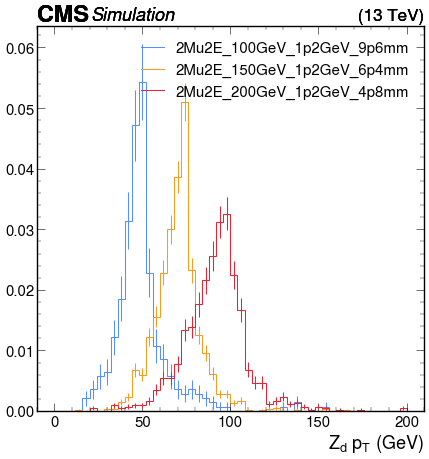

In [7]:
for sample in samples:
    utilities.plot(out[sample]["hists"]["genAs_pt"][channels[0], ::2j], density=True)
plt.legend(samples, alignment="left")